# Kaggle installation

These are steps to be followed to import the kaggle dataset to the colab runspace

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 5.0 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=2aec5114eafc6036c90c4b3fe9802643fcd957aec5470d0c6737abe00fb9fa75
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


Download the kaggle.json api token from your kaggle account and upload here


In [ ]:
#download kaggle.json from your account from create new api token
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pranavaramanbms","key":"34b741a6073b028c2af6dac99de176e4"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download plameneduardo/sarscov2-ctscan-dataset

 91% 209M/230M [00:05<00:00, 30.8MB/s]
100% 230M/230M [00:05<00:00, 40.7MB/s]


Exporting the files from the dataset.

In [ ]:
# importing required modules 
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "sarscov2-ctscan-dataset.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    #zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 

Extracting all the files now...
Done!


# Imports

In [ ]:
import os
import numpy as np
import tensorflow as tf
import math
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import random
import cv2

In [ ]:

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#%pylab inline


#from sklearn.model_selection import train_test_split


%load_ext tensorboard
import datetime
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##  Original model import

In [ ]:
!cp "/content/drive/MyDrive/Machine_Learning_Model_Files/COVID-19/vgg16pran.zip" original_vgg16_model.zip

In [ ]:
# importing required modules 
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "original_vgg16_model.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 

File Name                                             Modified             Size
saved_model/                                   2021-05-10 14:07:24            0
saved_model/vgg16pranmodel/                    2021-05-10 14:07:24            0
saved_model/vgg16pranmodel/assets/             2021-05-10 14:07:24            0
saved_model/vgg16pranmodel/variables/          2021-05-10 14:07:24            0
saved_model/vgg16pranmodel/variables/variables.data-00000-of-00001 2021-05-10 14:07:24    264409172
saved_model/vgg16pranmodel/variables/variables.index 2021-05-10 14:07:24         2963
saved_model/vgg16pranmodel/saved_model.pb      2021-05-10 14:07:24       354433
Extracting all the files now...
Done!


In [ ]:
#set the location to your model's location
model_location = 'saved_model/vgg16pranmodel'

from tensorflow.keras.models import load_model
model = load_model(model_location)
model.trainable = False

In [ ]:
#change to your model's input img_size
img_size = 224 

# custom-preprocessing function
def preprocessing_image(data):
    img_resize = cv2.resize(data, dsize=(img_size, img_size))
    image = np.array(img_resize, dtype='float32')
    image = tf.expand_dims(image,0)
    return image

#function that returns the predicted value
def prediction(data):
    value = model.predict(data)   
    return value[0][0]

This is the original model that can distinguish covid and non-covid


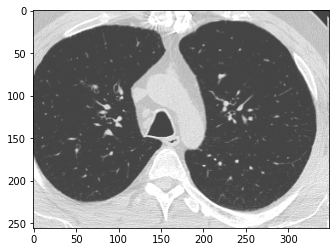

prediction for the above image is: 
1.0


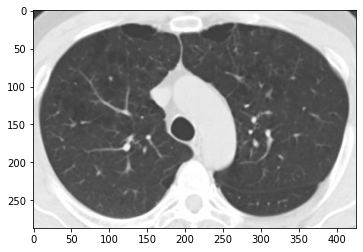

prediction for the above image is: 
4.3384417e-35


In [ ]:
#checking if the model works

print("This is the original model that can distinguish covid and non-covid")
image_locations = ['/content/COVID/Covid (100).png', "/content/non-COVID/Non-Covid (1001).png"]

for image_location in image_locations:

  image = cv2.imread(image_location)
  plt.imshow(image)
  image = preprocessing_image(image)
  plt.show()
  pred = prediction(image)
  print("prediction for the above image is: ")
  print(pred)

# FGSM ATTACK

In [ ]:
def FGSM(x, y_adv, epsilon):
    loss_func = tf.keras.losses.BinaryCrossentropy()
    with tf.GradientTape() as gt:
        gt.watch(x)
        
        label = model(x)
        loss = loss_func(y_adv, label)
        outputloss = loss.numpy()
        print (loss)
        
    grad = gt.gradient(loss, x)
    gamma = epsilon * tf.sign(grad)
    
    return x-gamma

In [ ]:
def create_perturb_fgsm(old_img, image_name, tofolder, y_val):

#old_img = cv2.imread(fromfolder+'/'+image_name)
  old_img = preprocessing_image(old_img)

  #actual prediction by the model
  preds = model.predict(old_img)
  print("The prediction of the image before attack: ", preds)

  #y_val = 0
    
  #if preds[0][0]<0.5:
    #y_val = 1
    
  #target value
  y_adv_label = y_val
  y_adv = tf.reshape(y_adv_label, shape=[1, preds.shape[-1]])


  #adverserial image

  x_adv = FGSM(old_img, y_adv, 1.4)

  #here noise is calculated to display it, it is not necessary to show the noise
  #noise = x_adv - img
  #plt.imshow(noise[0])
  #plt.show()


  #prediction by the model after adversarial attack
  newpreds = model.predict(x_adv)
  print("The prediction of the image after FGSM attack: %f" % ( newpreds[0][0]))

  #saving image to the destination
  save_img(tofolder+'/'+image_name, x_adv[0])


Example image:-

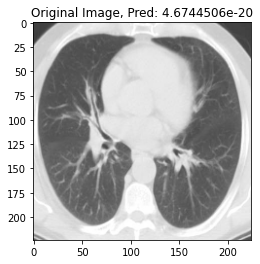

tf.Tensor(44.50959, shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


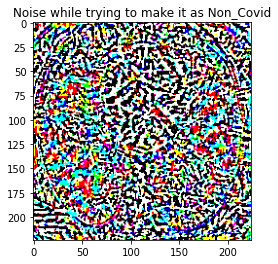

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The prediction of the image after FGSM attack while trying to make as Covid: 1.000000


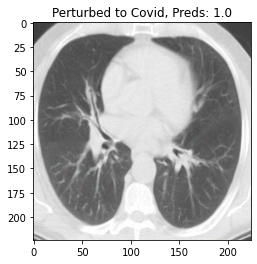

In [ ]:
from_folder = 'non-COVID'
image_name = 'Non-Covid (100).png'
#input image
img = cv2.imread(from_folder+'/'+image_name)
img = preprocessing_image(img)

#actual prediction by the model
preds = model.predict(img)
#print("The prediction of the image before attack: ", preds)

plt.imshow(img[0]/255)
plt.title('Original Image, Pred: '+str(preds[0][0]))
plt.show()


#target value
y_adv_label_0 = 1
y_adv_0 = tf.reshape(y_adv_label_0, shape=[1, preds.shape[-1]])


#adverserial image
x_adv_0 = FGSM(img,y_adv_0, 1.4)
#here noise is calculated to display it, it is not necessary to show the noise
noise_0 = x_adv_0 - img
plt.imshow(noise_0[0])
plt.title('Noise while trying to make it as Non_Covid')
plt.show()

#prediction by the model after adversarial attack
newpreds_0 = model.predict(x_adv_0)
print("The prediction of the image after FGSM attack while trying to make as Covid: %f" % (newpreds_0[0][0]))

plt.imshow(x_adv_0[0]/255)
plt.title('Perturbed to Covid, Preds: '+str(newpreds_0[0][0]))
plt.show()

In [ ]:
!mkdir FGSM_COVID_PERTURBED
!mkdir FGSM_COVID_PERTURBED/COVID
!mkdir FGSM_COVID_PERTURBED/non-COVID

In [ ]:
!rm -rf FGSM_COVID_PERTURBED
!rm -rf FGSM_COVID_PERTURBED/COVID
!rm -rf FGSM_COVID_PERTURBED/non-COVID

In [ ]:
img = [] #create a list of (image, prediction_label)
i=0
for data in os.listdir('COVID/'):
        img_d = cv2.imread('COVID/{}'.format(data))
        img_d = preprocessing_image(img_d)
        pred = prediction(img_d)  #get the prediction from the original model

        y_val = 0
        if pred>0.5:
          y_val = 1   #change the label

        img.append([img_d, y_val])    #append the image along with label in the list
        i+=1

In [ ]:

for data in os.listdir('non-COVID/'):
        img_d = cv2.imread('non-COVID/{}'.format(data))
        img_d = preprocessing_image(img_d)
        pred = prediction(img_d)  #get the prediction from the original model

        y_val = 1
        
        if pred<0.5:
          y_val = 0   #change the label
  
        img.append([img_d, y_val])    #append the image along with label in the list
        i+=1

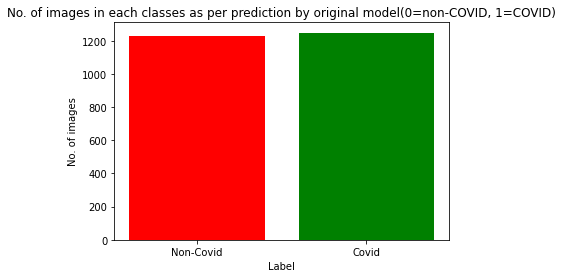

In [ ]:
img = np.array(img, dtype=object)
img[0][1]
img = np.array(img, dtype=object)
num_zeros = (img[:,1] == 0).sum()
num_ones = (img[:,1] == 1).sum()
plt.title('No. of images in each classes as per prediction by original model(0=non-COVID, 1=COVID)')
plt.ylabel('No. of images')
plt.xlabel('Label')
plt.bar(["Non-Covid", "Covid"], [num_zeros, num_ones] , color=["red", "green"])
plt.show()

In [ ]:
import random
from sklearn.model_selection import train_test_split
#random.shuffle(img)
X_img = []
Y_lab = []
for data in img:
    X_img.append(data[0][0])
    Y_lab.append(data[1])

X_arr_img = np.array(X_img)

X_train, X_test, Y_train, Y_test = train_test_split(X_arr_img, Y_lab, test_size=0.2)

X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

(array([249.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 248.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

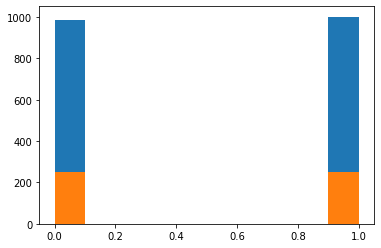

In [ ]:
plt.hist(Y_train)
plt.hist(Y_test)

In [ ]:
dr = 0
no_dr = 0

for i,d in enumerate(X_train):
  print(i)
  if Y_train[i] == 1:
    create_perturb_fgsm(d, 'COVID('+str(dr)+').png', 'FGSM_COVID_PERTURBED/COVID', 0)
    print('COVID('+str(dr)+').png')
    dr+=1
  else:
    create_perturb_fgsm(d, 'non-COVID('+str(no_dr)+').png', 'FGSM_COVID_PERTURBED/non-COVID', 1)
    print('non-COVID('+str(no_dr)+').png')
    no_dr+=1

Streaming output truncated to the last 5000 lines.
984
The prediction of the image before attack:  [[2.6054283e-20]]
tf.Tensor(45.094105, shape=(), dtype=float32)
The prediction of the image after FGSM attack: 1.000000
non-COVID(495).png
985
The prediction of the image before attack:  [[1.]]
tf.Tensor(56.846962, shape=(), dtype=float32)
The prediction of the image after FGSM attack: 0.000000
COVID(489).png
986
The prediction of the image before attack:  [[1.]]
tf.Tensor(52.71973, shape=(), dtype=float32)
The prediction of the image after FGSM attack: 0.000000
COVID(490).png
987
The prediction of the image before attack:  [[1.0654531e-30]]
tf.Tensor(69.01415, shape=(), dtype=float32)
The prediction of the image after FGSM attack: 1.000000
non-COVID(496).png
988
The prediction of the image before attack:  [[1.07656245e-10]]
tf.Tensor(22.952078, shape=(), dtype=float32)
The prediction of the image after FGSM attack: 1.000000
non-COVID(497).png
989
The prediction of the image before attack

In [ ]:
for i,d in enumerate(X_test):
  print(i)
  if Y_test[i] == 1:
    create_perturb_fgsm(d, 'COVID('+str(dr)+').png', 'FGSM_COVID_PERTURBED/COVID', 0)
    print('COVID('+str(dr)+').png')
    dr+=1
  else:
    create_perturb_fgsm(d, 'non-COVID('+str(no_dr)+').png', 'FGSM_COVID_PERTURBED/non-COVID', 1)
    print('non-COVID('+str(no_dr)+').png')
    no_dr+=1

0
The prediction of the image before attack:  [[2.2464206e-29]]
tf.Tensor(65.96563, shape=(), dtype=float32)
The prediction of the image after FGSM attack: 1.000000
non-COVID(983).png
1
The prediction of the image before attack:  [[1.]]
tf.Tensor(22.051308, shape=(), dtype=float32)
The prediction of the image after FGSM attack: 0.000000
COVID(1001).png
2
The prediction of the image before attack:  [[1.]]
tf.Tensor(46.228893, shape=(), dtype=float32)
The prediction of the image after FGSM attack: 0.000000
COVID(1002).png
3
The prediction of the image before attack:  [[2.6333723e-23]]
tf.Tensor(51.99119, shape=(), dtype=float32)
The prediction of the image after FGSM attack: 1.000000
non-COVID(984).png
4
The prediction of the image before attack:  [[0.9999932]]
tf.Tensor(11.893475, shape=(), dtype=float32)
The prediction of the image after FGSM attack: 0.000000
COVID(1003).png
5
The prediction of the image before attack:  [[6.5724504e-19]]
tf.Tensor(41.86623, shape=(), dtype=float32)
The

In [ ]:
!zip -r ./FGSM_COVID_PERTURBED.zip ./FGSM_COVID_PERTURBED/

  adding: FGSM_COVID_PERTURBED/ (stored 0%)
  adding: FGSM_COVID_PERTURBED/non-COVID/ (stored 0%)
  adding: FGSM_COVID_PERTURBED/non-COVID/non-COVID(958).png (deflated 1%)
  adding: FGSM_COVID_PERTURBED/non-COVID/non-COVID(1186).png (deflated 0%)
  adding: FGSM_COVID_PERTURBED/non-COVID/non-COVID(879).png (deflated 1%)
  adding: FGSM_COVID_PERTURBED/non-COVID/non-COVID(475).png (deflated 1%)
  adding: FGSM_COVID_PERTURBED/non-COVID/non-COVID(379).png (deflated 0%)
  adding: FGSM_COVID_PERTURBED/non-COVID/non-COVID(542).png (deflated 0%)
  adding: FGSM_COVID_PERTURBED/non-COVID/non-COVID(603).png (deflated 0%)
  adding: FGSM_COVID_PERTURBED/non-COVID/non-COVID(162).png (deflated 0%)
  adding: FGSM_COVID_PERTURBED/non-COVID/non-COVID(311).png (deflated 1%)
  adding: FGSM_COVID_PERTURBED/non-COVID/non-COVID(82).png (deflated 1%)
  adding: FGSM_COVID_PERTURBED/non-COVID/non-COVID(673).png (deflated 0%)
  adding: FGSM_COVID_PERTURBED/non-COVID/non-COVID(296).png (deflated 0%)
  adding: FGSM

In [ ]:
!cp ./FGSM_COVID_PERTURBED.zip "/content/drive/MyDrive/Machine_Learning_Model_Files/FGSM_COVID_PERTURBED.zip"

## evaluation of fgsm - bba

In [ ]:
!cp "/content/drive/MyDrive/Machine_Learning_Model_Files/FGSM_COVID_PERTURBED.zip" ./FGSM_COVID_PERTURBED.zip 

In [ ]:
# importing required modules 
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "FGSM_COVID_PERTURBED.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    #zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 

Extracting all the files now...
Done!


In [ ]:
import cv2

covid_img = []
for data in os.listdir('FGSM_COVID_PERTURBED/COVID'):
        img_d = cv2.imread('FGSM_COVID_PERTURBED/COVID/{}'.format(data))
        covid_img.append(img_d)

        
non_covid_img = []        
for data in os.listdir('FGSM_COVID_PERTURBED/non-COVID'):
        img_d = cv2.imread('FGSM_COVID_PERTURBED/non-COVID/{}'.format(data))        
        non_covid_img.append(img_d)


In [ ]:
covid_img = np.array(covid_img)
covid_img_pred = model.predict(covid_img)

In [ ]:
covid_img_pred_int = []
for i in covid_img_pred:
  if i < 0.5:
    covid_img_pred_int.append(0)
  else:
    covid_img_pred_int.append(1)

total no. of covid images =  1249
Predicted as Non - covid =  1183
Predicted as Covid =  66


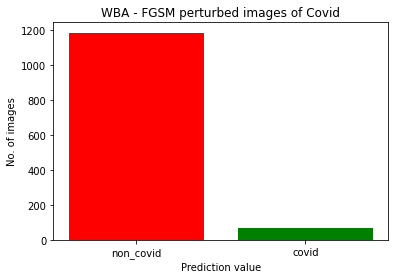

<Figure size 432x288 with 0 Axes>

In [ ]:
# no_of_zero = dr_new_pred.
covid_img_pred_int = np.array(covid_img_pred_int)
no_zero = (covid_img_pred_int ==0).sum()
no_one = (covid_img_pred_int==1).sum()
print("total no. of covid images = ", covid_img_pred.size)
print("Predicted as Non - covid = ",no_zero)
print("Predicted as Covid = ", no_one)

plt.title('WBA - FGSM perturbed images of Covid')
plt.ylabel('No. of images')
plt.xlabel('Prediction value')
plt.bar(["non_covid", "covid"], [no_zero, no_one] , color=["red", "green"])
plt.show()
plt.savefig('wba-fgsm-covid.eps', format='eps')

In [ ]:
!cp "wba-fgsm-covid.eps" "/content/drive/MyDrive/Colab Notebooks/retinopathy/Final colabs/April-Final Colabs/adversarial_attacks_graphs/wba-fgsm-covid.eps"

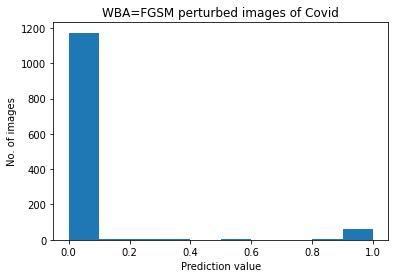

In [ ]:
plt.title('WBA=FGSM perturbed images of Covid')
plt.ylabel('No. of images')
plt.xlabel('Prediction value')
plt.hist(covid_img_pred.astype('float'))
plt.show()

In [ ]:
non_covid_img = np.array(non_covid_img)
non_covid_img_pred = model.predict(non_covid_img)

In [ ]:
non_covid_img_pred_int = []
for i in non_covid_img_pred:
  if i < 0.5:
    non_covid_img_pred_int.append(0)
  else:
    non_covid_img_pred_int.append(1)

total no. of non_covid images =  1232
Predicted as Non - covid =  8
Predicted as Covid =  1224


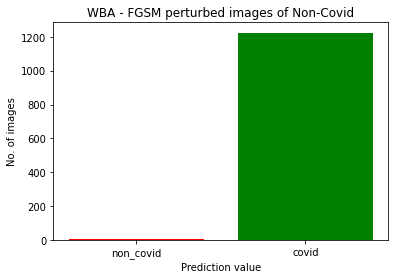

<Figure size 432x288 with 0 Axes>

In [ ]:
# no_of_zero = dr_new_pred.
non_covid_img_pred_int = np.array(non_covid_img_pred_int)
no_zero = (non_covid_img_pred_int ==0).sum()
no_one = (non_covid_img_pred_int==1).sum()
print("total no. of non_covid images = ", non_covid_img_pred.size)
print("Predicted as Non - covid = ",no_zero)
print("Predicted as Covid = ", no_one)


plt.title('WBA - FGSM perturbed images of Non-Covid')
plt.ylabel('No. of images')
plt.xlabel('Prediction value')
plt.bar(["non_covid", "covid"], [no_zero, no_one] , color=["red", "green"])
plt.show()
plt.savefig('wba-fgsm-non-covid.eps', format='eps')

In [ ]:
!cp "wba-fgsm-non-covid.eps" "/content/drive/MyDrive/Colab Notebooks/retinopathy/Final colabs/April-Final Colabs/adversarial_attacks_graphs/wba-fgsm-non-covid.eps"

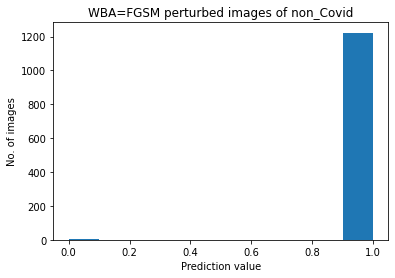

In [ ]:
plt.title('WBA=FGSM perturbed images of non_Covid')
plt.ylabel('No. of images')
plt.xlabel('Prediction value')
plt.hist(non_covid_img_pred.astype('float'))
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []
for i in covid_img_pred_int:
  y_pred.append(i)
  y_true.append(1)

for i in non_covid_img_pred_int:
  y_pred.append(i)
  y_true.append(0)

cnf = confusion_matrix(y_true, y_pred)
cnf

array([[   8, 1224],
       [1183,   66]])

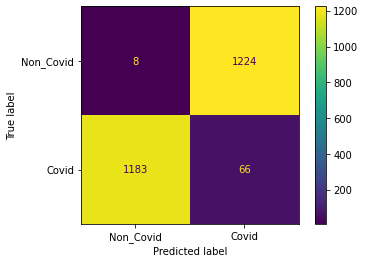

In [ ]:
disp = ConfusionMatrixDisplay(cnf,display_labels=["Non_Covid", "Covid"])
disp.plot()


# MIFGSM ATTACK

In [ ]:
def MIFGSM(input,y_adv,epsilon):
    loss_func = tf.keras.losses.BinaryCrossentropy()
    with tf.GradientTape() as gt:
        gt.watch(input)
        label = model(input)
        loss = loss_func(y_adv, label)
        outputloss = loss.numpy()
        # print (loss)
        
    data_grad = gt.gradient(loss, input)
    gamma = epsilon * tf.sign(data_grad)
    iter=20
    decay_factor=1
    pert_out = input
    alpha = epsilon/iter
    g=0
    for i in range(iter-1):
      g = decay_factor*g + data_grad/tf.norm(data_grad,ord=1,keepdims=None, name=None,axis=None)
      pert_out = pert_out - alpha*tf.sign(g)
      #pert_out = tf.clip_by_value(pert_out, 0, 1)
      if tf.norm((pert_out-input),ord=float('inf'),keepdims=None, name=None,axis=None) > epsilon:
        break
    return pert_out

# perturbation creation


In [ ]:
def create_perturb_mifgsm(old_img, image_name, tofolder, y_val):

#old_img = cv2.imread(fromfolder+'/'+image_name)
  old_img = preprocessing_image(old_img)

  #actual prediction by the model
  preds = model.predict(old_img)
  print("The prediction of the image before attack: ", preds)

  #y_val = 0
    
  #if preds[0][0]<0.5:
    #y_val = 1
    
  #target value
  y_adv_label = y_val
  y_adv = tf.reshape(y_adv_label, shape=[1, preds.shape[-1]])


  #adverserial image

  x_adv = MIFGSM(old_img, y_adv, 1.4)

  #here noise is calculated to display it, it is not necessary to show the noise
  #noise = x_adv - img
  #plt.imshow(noise[0])
  #plt.show()


  #prediction by the model after adversarial attack
  newpreds = model.predict(x_adv)
  print("The prediction of the image after MIFGSM attack: %f" % ( newpreds[0][0]))

  #saving image to the destination
  save_img(tofolder+'/'+image_name, x_adv[0])


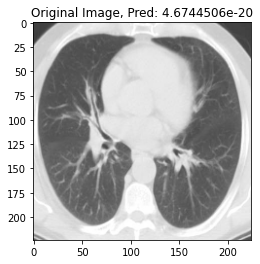

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


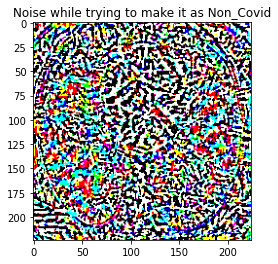

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The prediction of the image after FGSM attack while trying to make as Covid: 1.000000


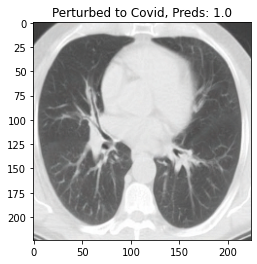

In [ ]:
from_folder = 'non-COVID'
image_name = 'Non-Covid (100).png'
#input image
img = cv2.imread(from_folder+'/'+image_name)
img = preprocessing_image(img)

#actual prediction by the model
preds = model.predict(img)
#print("The prediction of the image before attack: ", preds)

plt.imshow(img[0]/255)
plt.title('Original Image, Pred: '+str(preds[0][0]))
plt.show()


#target value
y_adv_label_0 = 1
y_adv_0 = tf.reshape(y_adv_label_0, shape=[1, preds.shape[-1]])


#adverserial image
x_adv_0 = MIFGSM(img,y_adv_0, 1.4)
#here noise is calculated to display it, it is not necessary to show the noise
noise_0 = x_adv_0 - img
plt.imshow(noise_0[0])
plt.title('Noise while trying to make it as Non_Covid')
plt.show()

#prediction by the model after adversarial attack
newpreds_0 = model.predict(x_adv_0)
print("The prediction of the image after FGSM attack while trying to make as Covid: %f" % (newpreds_0[0][0]))

plt.imshow(x_adv_0[0]/255)
plt.title('Perturbed to Covid, Preds: '+str(newpreds_0[0][0]))
plt.show()

In [ ]:
!rm -rf MIFGSM_WBA_COVID_perturbed

In [ ]:
!mkdir MIFGSM_WBA_COVID_perturbed
!mkdir MIFGSM_WBA_COVID_perturbed/non-COVID
!mkdir MIFGSM_WBA_COVID_perturbed/COVID

In [ ]:
img = [] #create a list of (image, prediction_label)
i=0
for data in os.listdir('COVID/'):
        img_d = cv2.imread('COVID/{}'.format(data))
        img_d = preprocessing_image(img_d)
        pred = prediction(img_d)  #get the prediction from the original model

        y_val = 0
        if pred>0.5:
          y_val = 1   #change the label

        img.append([img_d, y_val])    #append the image along with label in the list
        i+=1

In [ ]:
i=0
for data in os.listdir('non-COVID/'):
        img_d = cv2.imread('non-COVID/{}'.format(data))
        img_d = preprocessing_image(img_d)
        pred = prediction(img_d)  #get the prediction from the original model

        y_val = 1
        
        if pred<0.5:
          y_val = 0   #change the label
  
        img.append([img_d, y_val])    #append the image along with label in the list
        i+=1

New Histogram:


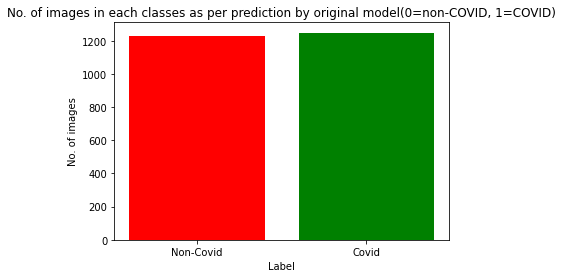

In [ ]:
img = np.array(img, dtype=object)
img[0][1]
img = np.array(img, dtype=object)
num_zeros = (img[:,1] == 0).sum()
num_ones = (img[:,1] == 1).sum()
print("New Histogram:")
plt.title('No. of images in each classes as per prediction by original model(0=non-COVID, 1=COVID)')
plt.ylabel('No. of images')
plt.xlabel('Label')
plt.bar(["Non-Covid", "Covid"], [num_zeros, num_ones] , color=["red", "green"])
plt.show()

In [ ]:
import random
from sklearn.model_selection import train_test_split
#random.shuffle(img)
X_img = []
Y_lab = []
for data in img:
    X_img.append(data[0][0])
    Y_lab.append(data[1])

X_arr_img = np.array(X_img)

X_train, X_test, Y_train, Y_test = train_test_split(X_arr_img, Y_lab, test_size=0.2)

X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

(array([244.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 253.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

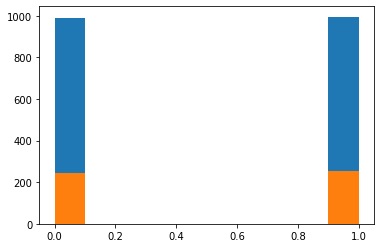

In [ ]:
plt.hist(Y_train)
plt.hist(Y_test)

In [ ]:
dr = 0
no_dr = 0

for i,d in enumerate(X_train):
  print(i)
  if Y_train[i] == 1:
    create_perturb_mifgsm(d, 'COVID('+str(dr)+').png', 'MIFGSM_WBA_COVID_perturbed/COVID', 0)
    print('COVID('+str(dr)+').png')
    dr+=1
  else:
    create_perturb_mifgsm(d, 'non-COVID('+str(no_dr)+').png', 'MIFGSM_WBA_COVID_perturbed/non-COVID', 1)
    print('non-COVID('+str(no_dr)+').png')
    no_dr+=1

Streaming output truncated to the last 5000 lines.
734
The prediction of the image before attack:  [[1.2400455e-13]]
The prediction of the image after MIFGSM attack: 1.000000
non-COVID(364).png
735
The prediction of the image before attack:  [[1.]]
The prediction of the image after MIFGSM attack: 0.000000
COVID(370).png
736
The prediction of the image before attack:  [[1.]]
The prediction of the image after MIFGSM attack: 0.000000
COVID(371).png
737
The prediction of the image before attack:  [[5.0609996e-09]]
The prediction of the image after MIFGSM attack: 1.000000
non-COVID(365).png
738
The prediction of the image before attack:  [[1.0645557e-22]]
The prediction of the image after MIFGSM attack: 1.000000
non-COVID(366).png
739
The prediction of the image before attack:  [[6.8912884e-18]]
The prediction of the image after MIFGSM attack: 1.000000
non-COVID(367).png
740
The prediction of the image before attack:  [[1.]]
The prediction of the image after MIFGSM attack: 0.000000
COVID(37

In [ ]:
for i,d in enumerate(X_test):
  print(i)
  if Y_test[i] == 1:
    create_perturb_mifgsm(d, 'COVID('+str(dr)+').png', 'MIFGSM_WBA_COVID_perturbed/COVID', 0)
    print('COVID('+str(dr)+').png')
    dr+=1
  else:
    create_perturb_mifgsm(d, 'non-COVID('+str(no_dr)+').png', 'MIFGSM_WBA_COVID_perturbed/non-COVID', 1)
    print('non-COVID('+str(no_dr)+').png')
    no_dr+=1

0
The prediction of the image before attack:  [[1.]]
The prediction of the image after MIFGSM attack: 0.000000
COVID(996).png
1
The prediction of the image before attack:  [[1.]]
The prediction of the image after MIFGSM attack: 0.000000
COVID(997).png
2
The prediction of the image before attack:  [[1.]]
The prediction of the image after MIFGSM attack: 0.000000
COVID(998).png
3
The prediction of the image before attack:  [[2.6054283e-20]]
The prediction of the image after MIFGSM attack: 1.000000
non-COVID(988).png
4
The prediction of the image before attack:  [[1.]]
The prediction of the image after MIFGSM attack: 0.000000
COVID(999).png
5
The prediction of the image before attack:  [[2.5328822e-18]]
The prediction of the image after MIFGSM attack: 1.000000
non-COVID(989).png
6
The prediction of the image before attack:  [[1.]]
The prediction of the image after MIFGSM attack: 0.000000
COVID(1000).png
7
The prediction of the image before attack:  [[1.]]
The prediction of the image after 

In [ ]:
!zip -r ./MIFGSM_WBA_COVID_perturbed.zip ./MIFGSM_WBA_COVID_perturbed/

  adding: MIFGSM_WBA_COVID_perturbed/ (stored 0%)
  adding: MIFGSM_WBA_COVID_perturbed/non-COVID/ (stored 0%)
  adding: MIFGSM_WBA_COVID_perturbed/non-COVID/non-COVID(958).png (deflated 0%)
  adding: MIFGSM_WBA_COVID_perturbed/non-COVID/non-COVID(1186).png (deflated 0%)
  adding: MIFGSM_WBA_COVID_perturbed/non-COVID/non-COVID(879).png (deflated 0%)
  adding: MIFGSM_WBA_COVID_perturbed/non-COVID/non-COVID(475).png (deflated 1%)
  adding: MIFGSM_WBA_COVID_perturbed/non-COVID/non-COVID(379).png (deflated 0%)
  adding: MIFGSM_WBA_COVID_perturbed/non-COVID/non-COVID(542).png (deflated 1%)
  adding: MIFGSM_WBA_COVID_perturbed/non-COVID/non-COVID(603).png (deflated 1%)
  adding: MIFGSM_WBA_COVID_perturbed/non-COVID/non-COVID(162).png (deflated 1%)
  adding: MIFGSM_WBA_COVID_perturbed/non-COVID/non-COVID(311).png (deflated 0%)
  adding: MIFGSM_WBA_COVID_perturbed/non-COVID/non-COVID(82).png (deflated 0%)
  adding: MIFGSM_WBA_COVID_perturbed/non-COVID/non-COVID(673).png (deflated 0%)
  adding: 

In [ ]:
!cp ./MIFGSM_WBA_COVID_perturbed.zip "/content/drive/MyDrive/Machine_Learning_Model_Files/MIFGSM_WBA_COVID_perturbed.zip"

## evaluation of MIFGSM - BBA

In [ ]:
!cp "/content/drive/MyDrive/Machine_Learning_Model_Files/MIFGSM_WBA_COVID_perturbed.zip" ./MIFGSM_WBA_COVID_perturbed.zip 

In [ ]:
# importing required modules 
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "MIFGSM_WBA_COVID_perturbed.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    #zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 

Extracting all the files now...
Done!


In [ ]:
import cv2

covid_img = []
for data in os.listdir('MIFGSM_WBA_COVID_perturbed/COVID'):
        img_d = cv2.imread('MIFGSM_WBA_COVID_perturbed/COVID/{}'.format(data))
        covid_img.append(img_d)

        
non_covid_img = []        
for data in os.listdir('MIFGSM_WBA_COVID_perturbed/non-COVID'):
        img_d = cv2.imread('MIFGSM_WBA_COVID_perturbed/non-COVID/{}'.format(data))        
        non_covid_img.append(img_d)


In [ ]:
covid_img = np.array(covid_img)
covid_img_pred = model.predict(covid_img)

In [ ]:
covid_img_pred_int = []
for i in covid_img_pred:
  if i < 0.5:
    covid_img_pred_int.append(0)
  else:
    covid_img_pred_int.append(1)

total no. of covid images =  1249
Predicted as Non - covid =  1173
Predicted as Covid =  76


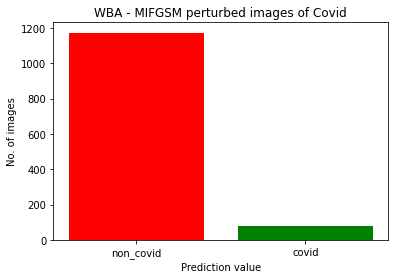

<Figure size 432x288 with 0 Axes>

In [ ]:
# no_of_zero = dr_new_pred.
covid_img_pred_int = np.array(covid_img_pred_int)
no_zero = (covid_img_pred_int ==0).sum()
no_one = (covid_img_pred_int==1).sum()
print("total no. of covid images = ", covid_img_pred.size)
print("Predicted as Non - covid = ",no_zero)
print("Predicted as Covid = ", no_one)

plt.title('WBA - MIFGSM perturbed images of Covid')
plt.ylabel('No. of images')
plt.xlabel('Prediction value')
plt.bar(["non_covid", "covid"], [no_zero, no_one] , color=["red", "green"])
plt.show()
plt.savefig('wba-mifgsm-covid.eps', format='eps')

In [ ]:
!cp "wba-mifgsm-covid.eps" "/content/drive/MyDrive/Colab Notebooks/retinopathy/Final colabs/April-Final Colabs/adversarial_attacks_graphs/wba-mifgsm-covid.eps"

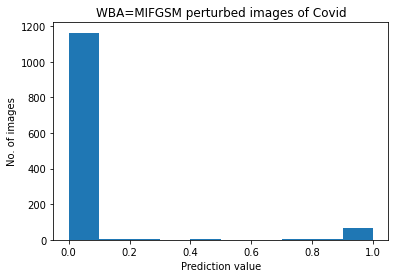

In [ ]:
plt.title('WBA=MIFGSM perturbed images of Covid')
plt.ylabel('No. of images')
plt.xlabel('Prediction value')
plt.hist(covid_img_pred.astype('float'))
plt.show()

In [ ]:
non_covid_img = np.array(non_covid_img)
non_covid_img_pred = model.predict(non_covid_img)

In [ ]:
non_covid_img_pred_int = []
for i in non_covid_img_pred:
  if i < 0.5:
    non_covid_img_pred_int.append(0)
  else:
    non_covid_img_pred_int.append(1)

total no. of non_covid images =  1232
Predicted as Non - covid =  9
Predicted as Covid =  1223


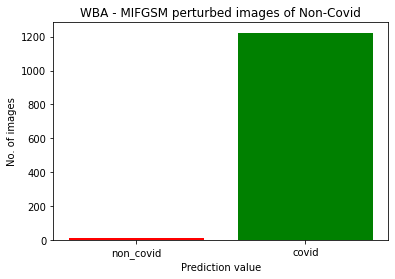

<Figure size 432x288 with 0 Axes>

In [ ]:
# no_of_zero = dr_new_pred.
non_covid_img_pred_int = np.array(non_covid_img_pred_int)
no_zero = (non_covid_img_pred_int ==0).sum()
no_one = (non_covid_img_pred_int==1).sum()
print("total no. of non_covid images = ", non_covid_img_pred.size)
print("Predicted as Non - covid = ",no_zero)
print("Predicted as Covid = ", no_one)


plt.title('WBA - MIFGSM perturbed images of Non-Covid')
plt.ylabel('No. of images')
plt.xlabel('Prediction value')
plt.bar(["non_covid", "covid"], [no_zero, no_one] , color=["red", "green"])
plt.show()
plt.savefig('wba-mifgsm-non-covid.eps', format='eps')

In [ ]:
!cp "wba-mifgsm-non-covid.eps" "/content/drive/MyDrive/Colab Notebooks/retinopathy/Final colabs/April-Final Colabs/adversarial_attacks_graphs/wba-mifgsm-non-covid.eps"

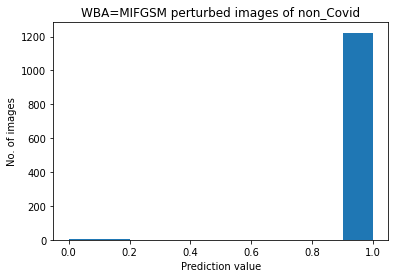

In [ ]:
plt.title('WBA=MIFGSM perturbed images of non_Covid')
plt.ylabel('No. of images')
plt.xlabel('Prediction value')
plt.hist(non_covid_img_pred.astype('float'))
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []
for i in covid_img_pred_int:
  y_pred.append(i)
  y_true.append(1)

for i in non_covid_img_pred_int:
  y_pred.append(i)
  y_true.append(0)

cnf = confusion_matrix(y_true, y_pred)
cnf

array([[   9, 1223],
       [1173,   76]])

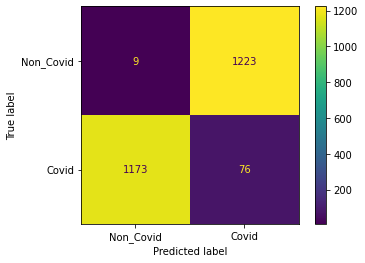

In [ ]:
disp = ConfusionMatrixDisplay(cnf,display_labels=["Non_Covid", "Covid"])
disp.plot()